# Setup

In [20]:
from neo4j import GraphDatabase
from neo4j import Session
import json
import pandas as pd
import matplotlib.pyplot as plt

with open('config.json') as f:
	config = json.load(f)

	uri = config['uri']
	username = config['username']
	password = config['password']

driver = GraphDatabase.driver(uri, auth=(username, password))


# Import Data

In [3]:
# Leggi il dataset
print("Caricamento del dataset...")
df = pd.read_csv('netflix.csv')
print(f"Dataset caricato con {len(df)} righe.")

# Preprocessing dei dati
print("Pulizia e preparazione dei dati...")
df['director'] = df['director'].fillna('')
df['cast'] = df['cast'].fillna('')
df['country'] = df['country'].fillna('')
df['date_added'] = df['date_added'].fillna('')
df['genres'] = df['genres'].fillna('')
df['rating'] = df['rating'].fillna('TV-MA')
df['duration'] = df['duration'].fillna('0 min')
print("Dati puliti e pronti per essere caricati nel database.")

# Funzione per creare nodi e relazioni
def create_nodes_and_relationships(tx, query, parameters=None):
    tx.run(query, parameters)

with driver.session() as session:
    # Creazione dei nodi per film e serie TV
    print("Creazione dei nodi per film e serie TV...")
    for idx, row in df.iterrows():
        if row['type'] == 'Movie':
            query = """
            CREATE (m:Movie {
                id: $id,
                title: $title,
                date_added: $date_added,
                release_year: $release_year,
                rating: $rating,
                duration: $duration,
                description: $description
            })
            """
        else:  # TV Show
            query = """
            CREATE (s:SerieTV {
                id: $id,
                title: $title,
                date_added: $date_added,
                release_year: $release_year,
                rating: $rating,
                seasons: $duration,
                description: $description
            })
            """
        session.execute_write(create_nodes_and_relationships, query, {
            'id': row['show_id'],
            'title': row['title'],
            'date_added': row['date_added'],
            'release_year': int(row['release_year']),
            'rating': row['rating'],
            'duration': row['duration'].replace(' min', '').replace(' Seasons', '').replace(' Season', ''),
            'description': row['description']
        })
        if idx % 100 == 0:
            print(f"Creati {idx+1} nodi di film/serie TV...")

    # Creazione dei nodi per le persone (registi e cast)
    print("Creazione dei nodi per registi e attori...")
    people = set()
    for _, row in df.iterrows():
        if row['director']:
            people.add(row['director'])
        cast_members = row['cast'].split(', ')
        people.update(cast_members)

    for idx, person in enumerate(people):
        if person:  # Salta stringhe vuote
            query = "CREATE (:Person {name: $name})"
            session.execute_write(create_nodes_and_relationships, query, {'name': person})
        if idx % 100 == 0:
            print(f"Creati {idx+1} nodi di persone...")

    # Collegare film e serie TV ai registi e al cast
    print("Creazione delle relazioni tra film/serie TV e registi/attori...")
    for idx, row in df.iterrows():
        if row['director']:
            query = """
            MATCH (p:Person {name: $name}), (m {id: $id})
            CREATE (p)-[:DIRECTED]->(m)
            """
            session.execute_write(create_nodes_and_relationships, query, {'name': row['director'], 'id': row['show_id']})

        cast_members = row['cast'].split(', ')
        for actor in cast_members:
            if actor:
                query = """
                MATCH (p:Person {name: $name}), (m {id: $id})
                CREATE (p)-[:ACTED_IN]->(m)
                """
                session.execute_write(create_nodes_and_relationships, query, {'name': actor, 'id': row['show_id']})
        if idx % 100 == 0:
            print(f"Create relazioni per {idx+1} film/serie TV...")

    # Creazione dei nodi per le categorie e collegamento con film e serie TV
    print("Creazione dei nodi per le categorie...")
    categories = set()
    for _, row in df.iterrows():
        genres = row['genres'].split(', ')
        categories.update(genres)

    for idx, category in enumerate(categories):
        if category:
            query = "CREATE (:Categoria {name: $name})"
            session.execute_write(create_nodes_and_relationships, query, {'name': category})
        if idx % 50 == 0:
            print(f"Creati {idx+1} nodi di categorie...")

    print("Collegamento dei film/serie TV alle categorie...")
    for idx, row in df.iterrows():
        genres = row['genres'].split(', ')
        for genre in genres:
            if genre:
                query = """
                MATCH (c:Categoria {name: $name}), (m {id: $id})
                CREATE (m)-[:IN_CATEGORY]->(c)
                """
                session.execute_write(create_nodes_and_relationships, query, {'name': genre, 'id': row['show_id']})
        if idx % 100 == 0:
            print(f"Collegate categorie per {idx+1} film/serie TV...")

    # Creazione dei nodi per i paesi e collegamento con film e serie TV
    print("Creazione dei nodi per i paesi...")
    countries = set()
    for _, row in df.iterrows():
        country_list = row['country'].split(',')
        country_list = [country.strip() for country in country_list]
        countries.update(country_list)

    for idx, country in enumerate(countries):
        if country:
            query = "CREATE (:Country {name: $name})"
            session.execute_write(create_nodes_and_relationships, query, {'name': country})
        if idx % 20 == 0:
            print(f"Creati {idx+1} nodi di paesi...")

    print("Collegamento dei film/serie TV ai paesi...")
    for idx, row in df.iterrows():
        country_list = row['country'].split(',')
        country_list = [country.strip() for country in country_list]
        for country in country_list:
            if country:
                query = """
                MATCH (c:Country {name: $name}), (m {id: $id})
                CREATE (m)-[:WHERE]->(c)
                """
                session.execute_write(create_nodes_and_relationships, query, {'name': country, 'id': row['show_id']})
        if idx % 100 == 0:
            print(f"Collegati paesi per {idx+1} film/serie TV...")

print("Tutti i dati sono stati caricati con successo nel database Neo4j!")
driver.close()


Transaction failed and will be retried in 0.9476028497865945s (Couldn't connect to localhost:7687 (resolved to ()):
Connection to [::1]:7687 closed without handshake response
Failed to read any data from server ResolvedIPv4Address(('127.0.0.1', 7687)) after connected (deadline Deadline(timeout=60.0)))


Caricamento del dataset...
Dataset caricato con 8807 righe.
Pulizia e preparazione dei dati...
Dati puliti e pronti per essere caricati nel database.
Creazione dei nodi per film e serie TV...


Transaction failed and will be retried in 2.1220798553335274s (Couldn't connect to localhost:7687 (resolved to ()):
Failed to read any data from server ResolvedIPv6Address(('::1', 7687, 0, 0)) after connected (deadline Deadline(timeout=60.0))
Failed to read any data from server ResolvedIPv4Address(('127.0.0.1', 7687)) after connected (deadline Deadline(timeout=60.0)))
Transaction failed and will be retried in 4.0758667565350315s (Couldn't connect to localhost:7687 (resolved to ()):
Failed to read any data from server ResolvedIPv6Address(('::1', 7687, 0, 0)) after connected (deadline Deadline(timeout=60.0))
Failed to read any data from server ResolvedIPv4Address(('127.0.0.1', 7687)) after connected (deadline Deadline(timeout=60.0)))


Creati 1 nodi di film/serie TV...
Creati 101 nodi di film/serie TV...
Creati 201 nodi di film/serie TV...
Creati 301 nodi di film/serie TV...
Creati 401 nodi di film/serie TV...
Creati 501 nodi di film/serie TV...
Creati 601 nodi di film/serie TV...
Creati 701 nodi di film/serie TV...
Creati 801 nodi di film/serie TV...
Creati 901 nodi di film/serie TV...
Creati 1001 nodi di film/serie TV...
Creati 1101 nodi di film/serie TV...
Creati 1201 nodi di film/serie TV...
Creati 1301 nodi di film/serie TV...
Creati 1401 nodi di film/serie TV...
Creati 1501 nodi di film/serie TV...
Creati 1601 nodi di film/serie TV...
Creati 1701 nodi di film/serie TV...
Creati 1801 nodi di film/serie TV...
Creati 1901 nodi di film/serie TV...
Creati 2001 nodi di film/serie TV...
Creati 2101 nodi di film/serie TV...
Creati 2201 nodi di film/serie TV...
Creati 2301 nodi di film/serie TV...
Creati 2401 nodi di film/serie TV...
Creati 2501 nodi di film/serie TV...
Creati 2601 nodi di film/serie TV...
Creati 2701 n

# Query 1

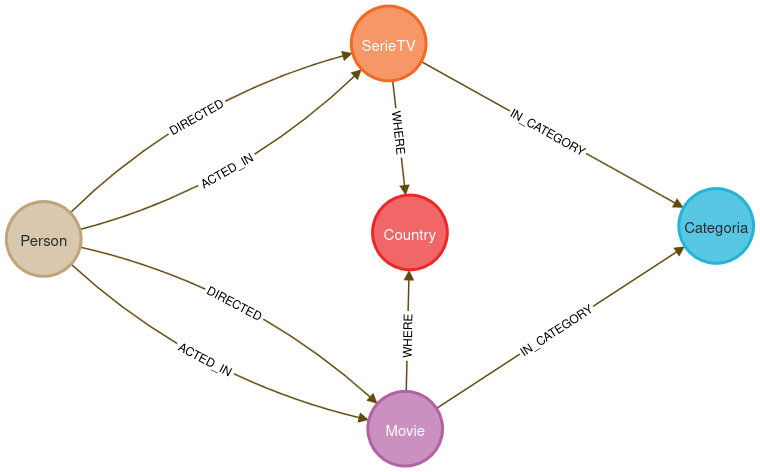

In [10]:
# import an image and show it
from PIL import Image
from IPython.display import display

img = Image.open('graph.png')
display(img)

# Query 2

In [16]:
# Estrarre i primi 5 attori come numero di film o serie TV a cui hanno partecipato

query = """
MATCH (p:Person)-[:ACTED_IN]->(m)
RETURN p.name, COUNT(m) AS num_movies
ORDER BY num_movies DESC
LIMIT 5
"""

session = driver.session()
result = session.run(query)

print("I primi 5 attori con il maggior numero di film/serie TV:")
for idx, record in enumerate(result):
	print(f"{idx+1}. {record['p.name']} ({record['num_movies']} film/serie TV)")

I primi 5 attori con il maggior numero di film/serie TV:
1. Anupam Kher (43 film/serie TV)
2. Shah Rukh Khan (35 film/serie TV)
3. Julie Tejwani (33 film/serie TV)
4. Naseeruddin Shah (32 film/serie TV)
5. Takahiro Sakurai (32 film/serie TV)


# Query 3

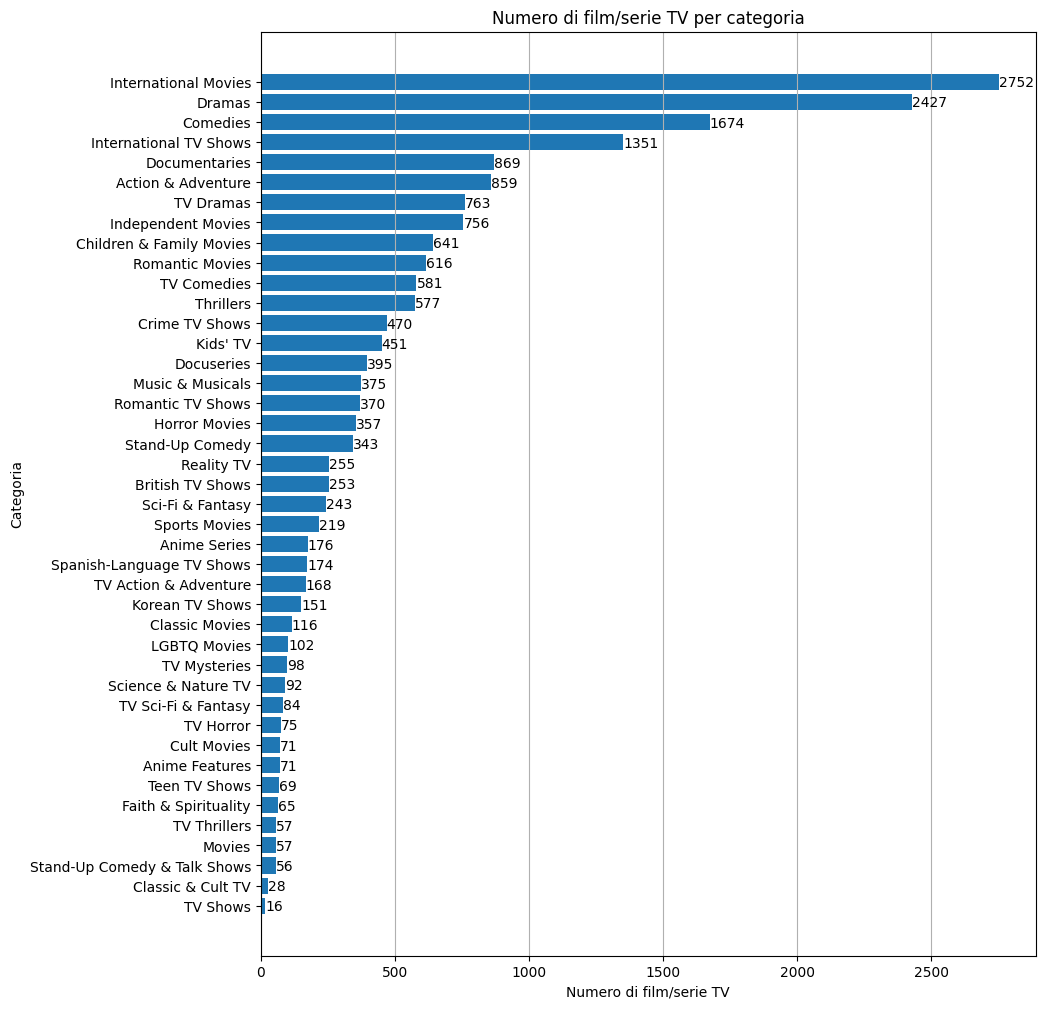

In [38]:
# Estrarre per ogni categoria il numero di film e serie TV di quella categoria, in ordine
# crescente, e visualizzare il risultato in un grafico a barre

query = """
MATCH (c:Categoria)<-[:IN_CATEGORY]-(m)
RETURN c.name AS category, COUNT(m) AS num_movies
ORDER BY num_movies ASC
"""

session = driver.session()
result = session.run(query)

categories = []
num_movies = []
for record in result:
	categories.append(record['category'])
	num_movies.append(record['num_movies'])

plt.figure(figsize=(10, 12))
plt.barh(categories, num_movies)
plt.xlabel('Numero di film/serie TV')
plt.ylabel('Categoria')
plt.title('Numero di film/serie TV per categoria')
plt.grid(axis='x')
# show values on bars
for i, v in enumerate(num_movies):
	plt.text(v, i - .25, str(v))
	# 
plt.show()


# Query 4

<Path start=<Node element_id='4:e8a13889-2530-46e5-a40c-164682b7c28d:8824' labels=frozenset({'Person'}) properties={'name': 'Andrew Phung'}> end=<Node element_id='4:e8a13889-2530-46e5-a40c-164682b7c28d:22628' labels=frozenset({'Person'}) properties={'name': 'Steven Spielberg'}> size=4>


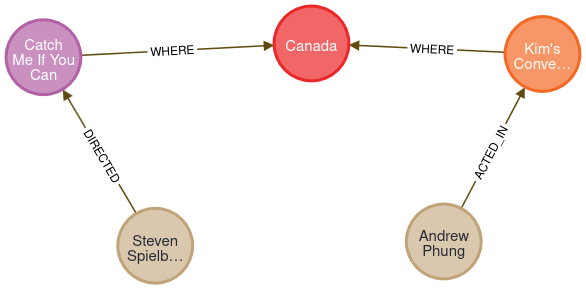

In [36]:
# Trovare il percorso più breve tra due persone (a scelta dello studente) e visualizzarlo
# come sottografo

actor1 = 'Andrew Phung'
actor2 = 'Steven Spielberg'

query = """
MATCH (p1:Person {name: $actor1}), (p2:Person {name: $actor2}),
path = shortestPath((p1)-[*]-(p2))
RETURN path
"""

session = driver.session()
result = session.run(query, {'actor1': actor1, 'actor2': actor2})

for record in result:
	print(record['path'])

img = Image.open('shortest.png')
display(img)


# Query 5

In [91]:
# Query per ottenere i film associati a ciascuna categoria
query = """
MATCH (c:Categoria)<-[:IN_CATEGORY]-(m)
RETURN c.name AS category, COLLECT(m.title) AS movies
"""

session = driver.session()
result = session.run(query)


category_movies = {}
for record in result:
    category = record['category']
    movies = set(record['movies'])
    category_movies[category] = movies

# Calcolo della similarità tra tutte le coppie di categorie
similarities = []
categories = list(category_movies.keys())

for i in range(len(categories)):
    for j in range(i + 1, len(categories)):
        catA = categories[i]
        catB = categories[j]

        # Insiemi di film
        moviesA = category_movies[catA]
        moviesB = category_movies[catB]

        # Calcolo della similarità
        intersection = len(moviesA & moviesB)  # |A ∩ B|
        min_cardinality = min(len(moviesA), len(moviesB))  # min(|A|, |B|)
        similarity = intersection / min_cardinality if min_cardinality > 0 else 0

        # Salvare il risultato
        similarities.append((catA, catB, similarity))

# Stampare i risultati
print("Similarità tra categorie:")
count = 0
for catA, catB, similarity in similarities:
    if similarity > 0:
        count += 1
        print(f"Sim({catA}, {catB}) = {similarity:.2f}")
        
print(f"Numero di coppie di categorie con similarità > 0: {count}")


Similarità tra categorie:
Sim(Romantic Movies, Comedies) = 0.45
Sim(Romantic Movies, Faith & Spirituality) = 0.06
Sim(Romantic Movies, Anime Features) = 0.04
Sim(Romantic Movies, Thrillers) = 0.01
Sim(Romantic Movies, Children & Family Movies) = 0.03
Sim(Romantic Movies, Music & Musicals) = 0.04
Sim(Romantic Movies, Horror Movies) = 0.01
Sim(Romantic Movies, Action & Adventure) = 0.03
Sim(Romantic Movies, Sci-Fi & Fantasy) = 0.03
Sim(Romantic Movies, LGBTQ Movies) = 0.05
Sim(Romantic Movies, Dramas) = 0.50
Sim(Romantic Movies, Sports Movies) = 0.02
Sim(Romantic Movies, International Movies) = 0.60
Sim(Romantic Movies, Independent Movies) = 0.05
Sim(Romantic Movies, Classic Movies) = 0.03
Sim(Korean TV Shows, International TV Shows) = 0.85
Sim(Korean TV Shows, TV Horror) = 0.01
Sim(Korean TV Shows, Reality TV) = 0.04
Sim(Korean TV Shows, Crime TV Shows) = 0.13
Sim(Korean TV Shows, TV Action & Adventure) = 0.04
Sim(Korean TV Shows, TV Comedies) = 0.09
Sim(Korean TV Shows, Stand-Up Comedy

# Query 6

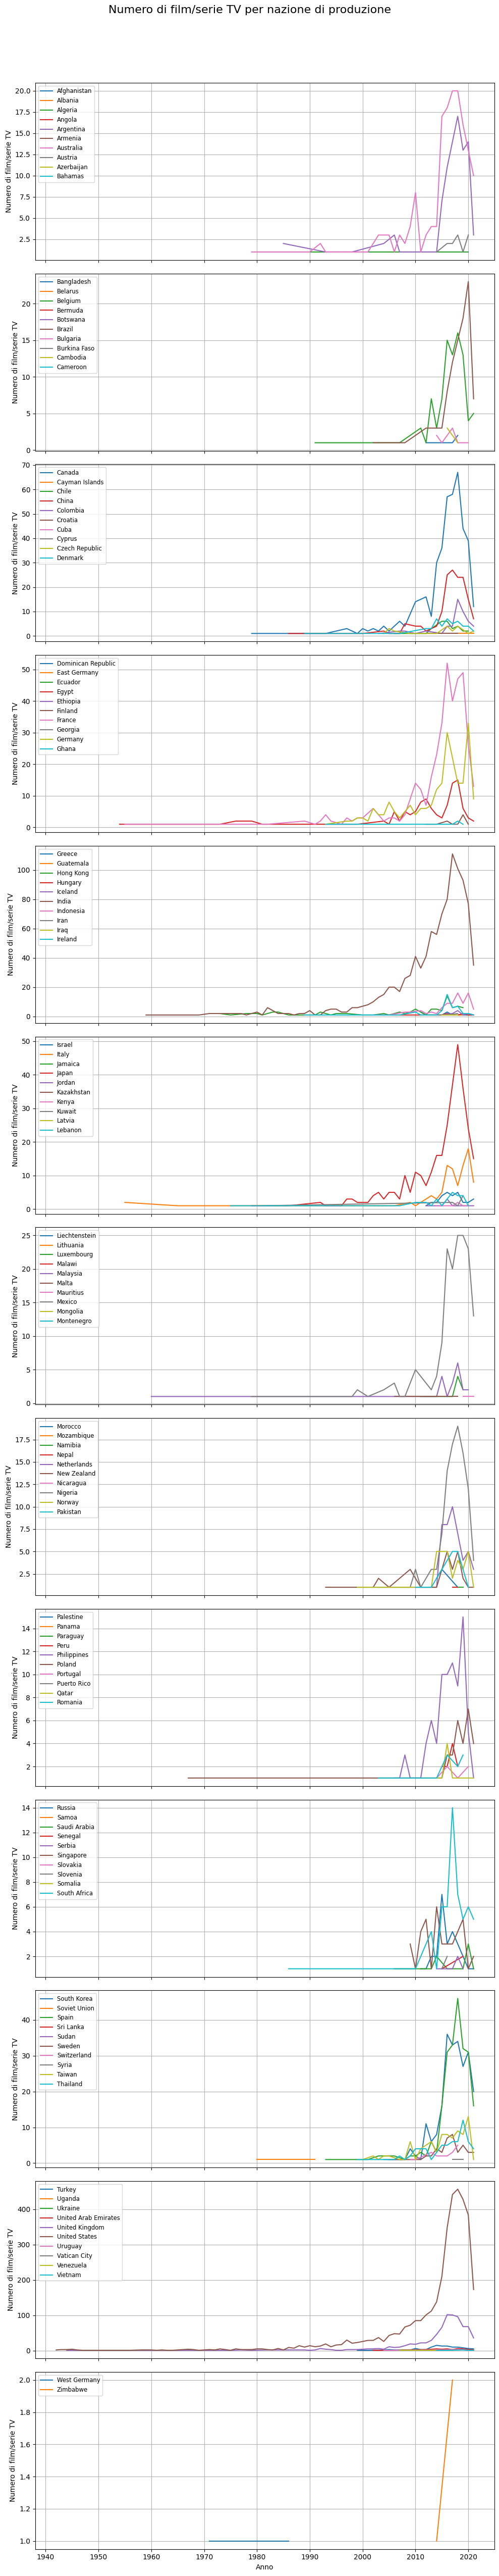

In [88]:
# Riportare in un grafico l’evoluzione nel tempo del numero di film o serie TV per ogni
# nazione di produzione (il grafico presenterà gli anni sull’asse delle ascisse e N grafici
# ognuno riportante il numero di film e serie TV per ogni nazione al variare del tempo)

query = """
MATCH (c:Country)<-[:WHERE]-(m)
RETURN c.name AS country, m.release_year AS year, COUNT(m) AS num_movies
ORDER BY country, year
"""

session = driver.session()
result = session.run(query)

countries = {}
for record in result:
	country = record['country']
	year = record['year']
	num_movies = record['num_movies']

	if country not in countries:
		countries[country] = {'years': [], 'num_movies': []}

	countries[country]['years'].append(year)
	countries[country]['num_movies'].append(num_movies)

countries_per_subplot = 10
country_list = list(countries.keys())
num_subplots = (len(country_list) + countries_per_subplot - 1) // countries_per_subplot

# Create subplots
fig, axes = plt.subplots(num_subplots, 1, figsize=(10, 4 * num_subplots), sharex=True)
if num_subplots == 1:
    axes = [axes]

for i in range(num_subplots):
    start = i * countries_per_subplot
    end = start + countries_per_subplot
    countries_subset = country_list[start:end]

    ax = axes[i]
    for country in countries_subset:
        data = countries[country]
        ax.plot(data['years'], data['num_movies'], label=country)

    ax.set_ylabel('Numero di film/serie TV')
    ax.grid()
    ax.legend(loc='upper left', fontsize='small')

axes[-1].set_xlabel('Anno')
fig.suptitle('Numero di film/serie TV per nazione di produzione', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
